# Gaussian Process Regression


**Gaussian Process Regression (GPR)** is a non-parametric approach to describe the relationships between variables without specifying the underlying distribution. By choosing Gaussian distributions to model the data, you benefit from their properties, for example that the marginal and conditional distributions are also Gaussian [1]. 


## Gaussian Process

A **Gaussian Process (GP)** is a generalization of a multivariate Gaussian distribution to *infinite dimension* and used to describe a distribution over functions. It defines a prior distribution over functions from which a posterior distribution can be inferred when data is observed.
A GP is completely specified by a mean function $m(x)$ and a covariance function $k(x,x')$ of a real process $f(x)$:    

$$f(x) \sim GP(m(x),k(x,x')).$$     
Usually, the mean value is set to $m(x)=0$ since the GP is flexible enough to model the mean arbitrarily well.
The function values $f(x_1),...,f(x_n)$ are jointly Gaussian, corresponding to any number of input points $n$ [1,2,3]. 


## Kernels

**Kernels** are used as *similarity measure* between objects and define the covariance matrix $\Sigma$. A kernel $k$ is a positive definite kernel function and describes the shape of the distribution as well as characteristics of the function we want to predict. If two points $x$ and $x'$ are deemed by the kernel to be similar, then we expect the output of the function at those points to be similar, too. The kernel function $k$ is a real-valued function of two arguments, $k(x,x') \in \mathbb{R}$. To retrieve the covariance matrix $\Sigma$, we evaluate $k$ on each pairwise combination of the set of points, $k: \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R},~ \Sigma = Cov(X,X') = k(x,x')$.  
The most common kernel functions are the following:  

* Radial Basis Function (RBF): $k(x,x')= \sigma^2 exp(- \frac{||x-x'||^2}{2\ell^2}) $  
The RBF kernel is a stationary kernel, hence it is invariant to translations and the covariance between two points depends only on their relative positions. Scale factor $\sigma^2$ is the variance controlling vertical variation, and describing the average distance of the function away from its mean. Parameter $\ell$ determines the horizontal lengthscale ober which the function varies, and determines the reach of influence on the neighbors. 


* Linear: $k(x,x') = \sigma_b^2 + \sigma^2(x-c)(x'-c)$  
The linear kernel is a non-stationary kernel, so the covariance between two points depends on their absolute positions. Parameter $c$ determines the point on which all posterior functions hinge. The constant variance $\sigma_b$ describes how far from 0 the height of the function will be at zero, hence adding an uncertain offset to the model [2,4].


## Prior

We define the **prior** as a GP over the test set $X_*$, where each test point is treated as a random variable. In our example, we choose $|X_*|=N=50$ linearly-spaced values from 0 to 15 as test set to get the prior $P_{X_*}$ before any data is observed. The prior has dimensionality $N$ and revolves around $\mu=0$. The covariance matrix $\Sigma_{**}$ is computed by applying the kernel function $k$ to the test points $X_*$, $\Sigma_{**} = k(X_*,X_*)$. 
To demonstrate realizations of a GP we implement the prior distribution as previously described with following hyperparameters:  
* RBF: $\sigma^2 = 0.5,~ \ell = 2$  
* Linear: $\sigma^2 = 0.5,~ \sigma_b = 2,~ c = 0.5$  

and generate a random Gaussian vector $f_* \sim \mathcal{N}(\mu, k(X_*,X_*)) = \mathcal{N}(0,\Sigma_{**})$ to sample five functions from each Prior.

(50, 50)
[ 0.63807461  0.63664766  0.60402501  0.54614801  0.4686684   0.37605405
  0.2715345   0.15766655  0.03710616 -0.08681483 -0.20993466 -0.32752941
 -0.43483413 -0.52759989 -0.60252358 -0.65748396 -0.69159411 -0.70510855
 -0.69922255 -0.67580426 -0.63712193 -0.58565156 -0.52404293 -0.45524847
 -0.38270948 -0.31040051 -0.24253356 -0.18284704 -0.13360988 -0.09467069
 -0.06296325 -0.03278626  0.00307433  0.0516153   0.11775946  0.20292452
  0.30444574  0.41600161  0.52886347  0.63354705  0.7213668   0.78551175
  0.82151724  0.82726011  0.8027729   0.7501441   0.67361435  0.57974323
  0.47736108  0.37701097]
[-1.03122477 -1.04574913 -1.07564212 -1.12701423 -1.20035401 -1.28977429
 -1.3834961  -1.4655576  -1.51845368 -1.52616661 -1.476924   -1.36509036
 -1.19185294 -0.96472362 -0.69619551 -0.40204813 -0.0997326   0.19294676
  0.45887991  0.68260672  0.85135274  0.95618692  0.99316309  0.96416882
  0.87716385  0.74556009  0.58665604  0.41926229  0.26088363  0.12500968
  0.01912458 -0.

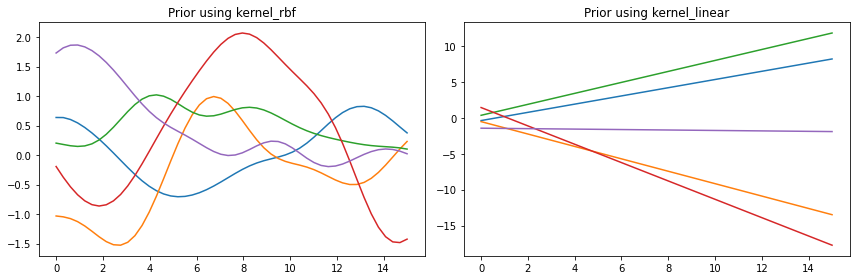

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt



def kernel_rbf(x, y, param):
    """ Radial Basis Function Kernel 
    
    Parameters:
    x : numpy array with N dimensions of 1 element
        First input vector of kernel
    y : numpy array with N dimensions of 1 element
        Second input vector of kernel
    param : dictionary
        Contains scale factor variance, and lengthscale ell
        
    Returns:
        Covariance matrix of each pairwise combination of set of points
    """
    variance = param['var']
    lengthscale = param['ell']
    # Euclidean distance between points
    eucdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T)
    return variance * np.exp(-0.5 * eucdist * 1/(lengthscale**2))
    
    
def kernel_linear(x, y, param):
    """ Linear Kernel
    
    Parameters:
    x : numpy array with N dimensions of 1 element
        First input vector of kernel
    y : numpy array with N dimensions of 1 element
        Second input vector of kernel
    param : dictionary
        Contains scale factor variance, variance_b, and offset off
        
    Returns: 
        Covariance matrix of each pairwise combination of set of points
    """
    variance = param['var']
    variance_b = param['var_b']
    offset = param['off']
    return variance_b + variance * np.dot((x-offset), (y-offset).T)



# define all hyperparameters for all kernels
params = {'var': 0.5,
          'ell': 2,        # larger l -> less wiggles
          'var_b': 2,
          'off': 0.5}


# Test Data: N points from 0 to 15
N_s = 50
X_s = np.linspace(0, 15, N_s).reshape(-1,1)


# Priors using RBF and linear kernel
plt.figure(figsize=(12, 4))

for i, kernel in enumerate([kernel_rbf, kernel_linear]):
    # compute mean and covariance
    mu_prior = np.zeros(X_s.shape)
    cov_prior = kernel(X_s, X_s, params)
    # sample 5 normals from GP prior and plot
    print(np.shape(cov_prior))
    f_prior = np.random.multivariate_normal(mu_prior.ravel(), cov_prior, 5)
    plt.subplot(1, 2, (i+1))
    for sample in f_prior:
        print(sample)
        plt.plot(X_s, sample, lw=1.5, ls='-')
        plt.title(f'Prior using {kernel.__name__}')
plt.tight_layout()        
plt.show()



## Combination of kernels

It is possible to combine two kernels, what is especially useful when they are defined on different inputs to the function. A standard way is to **multiply** two kernels, then the resulting kernel will have high value only if both of the base kernels have a high value. You can think of it as an *AND* operation. In contrast, **adding** two kernels can be thought of as an *OR* operation. That means that the resulting kernel will have high value if either of the two base kernels have a high value [4].

In [1]:
def kernel_mult(x, y, param):
    """ Multiply RBF and Linear Kernel
    """
    return kernel_rbf(x, y, param) * kernel_linear(x, y, param)

def kernel_add(x, y, param):
    """ Add RBF and Linear Kernel
    """
    return kernel_rbf(x, y, param) + kernel_linear(x, y, param)


# Priors using combinations of kernels
plt.figure(figsize=(12, 4))

for i, kernel in enumerate([kernel_mult, kernel_add]):
    # compute mean and covariance
    mu_prior = np.zeros(X_s.shape)
    cov_prior = kernel(X_s, X_s, params)
    # sample 5 normals from GP prior and plot
    f_prior = np.random.multivariate_normal(mu_prior.ravel(), cov_prior, 5)
    plt.subplot(1, 2, (i+1))
    for sample in f_prior:
        plt.plot(X_s, sample, lw=1.5, ls='-')
        plt.title(f'Prior using {kernel.__name__}')
plt.tight_layout()        
plt.show()


NameError: name 'plt' is not defined

## Observations

Now we want to incorporate knowledge from collected **training data**. First, we assume that we obtained perfect measurements and have *noise-free* observations. We get the training set $\{(x_i,f_i)|i=1,...,n\}$, consisting of inputs $X$ and function outputs $f$. 
Given our test set $X_*$ and our training data $\{X,~ f\}$, we want to predict the function outputs $f_*$. 


The *joint distribution* of training and test outputs is: $\begin{bmatrix} f \\ f_* \end{bmatrix} \sim \mathcal{N} \begin{pmatrix} \begin{bmatrix} \mu \\ \mu_* \end{bmatrix}, \begin{bmatrix} \Sigma & \Sigma_* \\ \Sigma_*^T & \Sigma_{**} \end{bmatrix} \end{pmatrix} $,  

where $\Sigma$ denotes the covariance matrix evaluated at all paris of training points $X$, $\Sigma_*$ at training and test points, and $\Sigma_{**}$ at test points $X_*$, and $\mu=\mu_*=0$.  

The **posterior distribution** $p(f_*|X_*,X,f)$ can be derived by *conditioning* the joint Gaussian prior distributions on the observations. We get:  

\begin{align}
f_*|X_*,X,f \sim \mathcal{N}(\Sigma_*^T \Sigma^{-1}f,~ \Sigma_{**} - \Sigma_*^T \Sigma^{-1} \Sigma_*) 
\label{eq:post}\tag{1}
\end{align}

The function values $f_*$ can be sampled from the joint posterior distribution by evaluating the mean and covariance matrix and generating samples. 


According to [2]: For reasons of numerical stability, it is unwise to directly invert $\Sigma$. More robust alternative: Cholesky decomposition, $\Sigma = LL^T$. Then, solve for $\alpha = \Sigma^{-1}f = L^{-T}L^{-1}f$. Compute mean using $\Sigma_*^T \alpha$ and variance using $\Sigma_{**} - \Sigma_*^T L^{-T} L^{-1} \Sigma_*$.


We have data for bee colonies of size $n=2, 3, 5, 10$ available. Below you can see the respective histograms we got after the experiments.

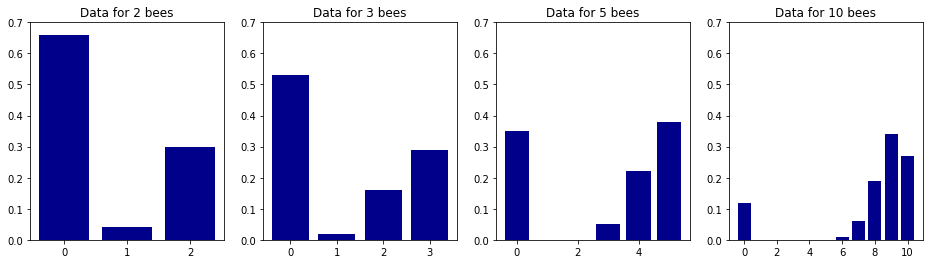

In [38]:
# Data: observations for 2, 3, 5, and 10 bees
colony_sizes = [2, 3, 5, 10]
observations = [(0.66, 0.04, 0.3), 
                (0.53, 0.02, 0.16, 0.29),
                (0.35, 0.0, 0.0, 0.05, 0.22, 0.38),
                (0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.06, 0.19, 0.34, 0.27)]

plt.figure(figsize=(16, 4))

for i, size in enumerate(colony_sizes):
    obs = observations[i]
    idx = np.arange(size+1)
    plt.subplot(1,4,(i+1))
    plt.bar(idx, obs, 0.8, color="darkblue")
    plt.yticks(np.arange(0, 0.71, 0.1))
    plt.title(f'Data for {size} bees')
plt.show()

# number of living bees after experiment

For a colony of size $n$, we have $n+1$ possible outcomes $o=(0,1,...,n) \in \mathbb{N}^{n+1}$ with the associated probabilities $p=(p_0,...,p_n) \in \mathbb{R}^{n+1}$.  
Since it is difficult to process and predict a whole distribution, we start by computing only the first statistical moment of the histogram, its mean value,   

$$\overline{x} = \sum_i (p_io_i).$$   

Therefore, our training data consists of inputs (colony size) $X=[2,3,5,10]$ and outputs (mean value) $f=[0.64,1.21,2.93,7.76]$.  
We now sample from the GP posterior after conditioning on the four mentioned observations. The shaded area represents the uncertainty as the $95\%$ confidence region (pointwise mean $\pm$ two times the standard deviation for each input value).  

Note that the variance is zero in a noise-free model, and that all functions go directly through the training points [2,5].

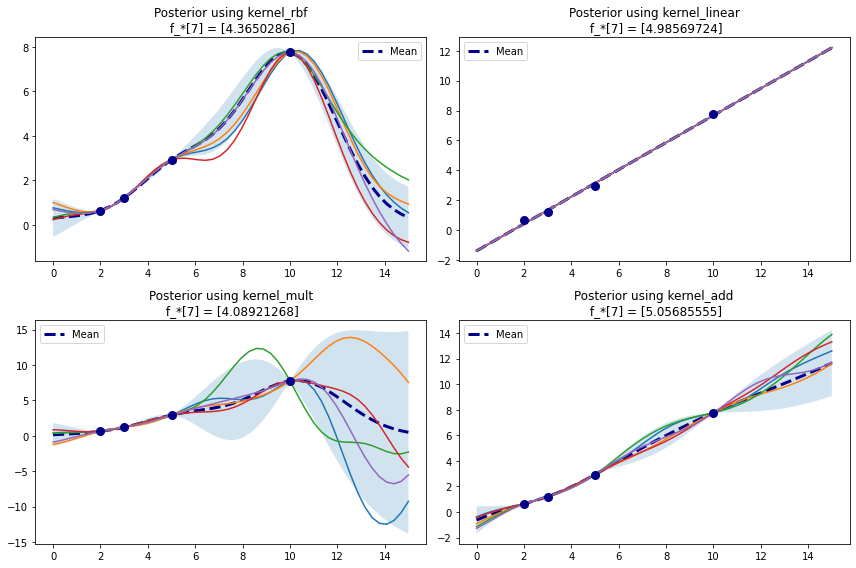

In [39]:
def posterior(X, X_s, f, kernel=kernel_rbf, params=params, noise=1e-15):
    """ Derive Posterior Distribution using Equation (1)
    
    Parameters:
    X : numpy array with N dimensions of 1 element
        Training Data inputs 
    X_s : numpy array with N dimensions of 1 element
        Test Data inputs
    f : numpy array with N dimensions of 1 element
        Training Data outputs
    kernel : function (default: rbf kernel)
        Kernel function to compute covariance matrix
    params : dictionary
        Hyperparameters for kernel functions
    noise : float
        Noise to add to data
        
    Returns:
    mu_s : numpy array with N dimensions of 1 element
        Mean vector of posterior distribution
    sigma_s : numpy array with N x N dimensions
        Covariance matrix of posterior distribution
    """
    N, N_s = len(X), len(X_s)
    # Add noise to observations
    cov = kernel(X, X, params) + noise * np.eye(N)             # old:  + noise**2 * np.eye(N)
    cov_s = kernel(X, X_s, params)                             # + 1e-5 * np.eye(N,N_s)
    cov_ss = kernel(X_s, X_s, params)                          # + 1e-5 * np.eye(N_s)
    
    # Cholesky decomposition for numerical stability of matrix inversion
    L = np.linalg.cholesky(cov + 1e-5 * np.eye(N))
    alpha_1 = np.linalg.solve(L, f)
    alpha = np.linalg.solve(L.T, alpha_1)
    mu_s = cov_s.T.dot(alpha)
    
    v = np.linalg.solve(L, cov_s)
    sigma_s = cov_ss - v.T.dot(v)
    
    # without Cholesky:
    #mu_s = cov_s.T.dot(np.linalg.inv(cov)).dot(f)
    #sigma_s = cov_ss - cov_s.T.dot(np.linalg.inv(cov)).dot(cov_s)
    
    return mu_s, sigma_s



def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[], ax0=plt, pred=7):
    """ Plot GP with mean function & uncertainty
    Adapted from: https://github.com/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_util.py
    
    Parameters:
    mu : numpy array with N dimensions of 1 element
        Mean vector of (posterior) distribution
    cov : numpy array with N x N dimensions
        Covariance matrix of posterior distribution
    X : numpy array with N dimensions of 1 element
        Test Data inputs
    X_train : numpy array with N dimensions of 1 element
        Training Data inputs
    Y_train : numpy array with N dimensions of 1 element
        Training Data outputs
    samples : numpy array with 5 x N dimensions
        Drawn samples from GP
    ax0 : plot
        Plot to draw GP on
    pred : int (default: 7)
        Specifies a test point with its prediction
    """
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
        
    ax0.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.2)
    ax0.plot(X, mu, '--', color='darkblue', lw=3, label='Mean')
    for i, sample in enumerate(samples):
        ax0.plot(X, sample, lw=1.5)
    if X_train is not None:
        ax0.plot(X_train, Y_train, 'o', ms=8, color='darkblue')
    ax0.legend()



# Noise free Training data
X = np.array([2,3,5,10]).reshape(-1,1)
N = len(X)
f = np.array([0.64,1.21,2.93,7.76]).reshape(-1,1)


# Poster using all kernels & combinations
plt.figure(figsize=(12, 8))

for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_mult, kernel_add]):
    # compute mean and covariance of the posterior distribution and draw 5 samples
    mu_post, cov_post = posterior(X, X_s, f, kernel, params)
    samples = np.random.multivariate_normal(mu_post.ravel(), cov_post, 5)
    idx_pred = np.absolute(X_s-7).argmin()
    plt.subplot(2,2,(i+1))
    plot_gp(mu_post, cov_post, X_s, X, f, samples)
    # compute prediction for x* = 7
    plt.title(f'Posterior using {kernel.__name__}\n f_*[7] = {mu_post[idx_pred]}')
plt.tight_layout()        
plt.show()




## Noisy Observations

Normally, we do not have perfect data, but some noise available due to measurement errors, for example. In this case, the training points are only approximated and the variance is not zero at those training points.   
If we assume that the observational noise is normally distributed, the posterior is still a GP and the inference analytically tractable. 
We assume $y = f(x) + \epsilon$ with $f \sim GP(0,\Sigma)$ and $\epsilon \sim \mathcal{N}(0, \sigma_f^2I)$. The noise variance $\sigma_f^2$ is an additional parameter of the likelihood and independently added to each observation. We get:  

$p(y|f) = \mathcal{N}(y|f,\sigma_f^2I).$  

We can then write the joint distribution of training and test values as  

$$ \begin{bmatrix} y \\ f_* \end{bmatrix} \sim \mathcal{N} \begin{pmatrix} 0, \begin{bmatrix} \Sigma_y & \Sigma_* \\ \Sigma_*^T & \Sigma_{**} \end{bmatrix} \end{pmatrix} $$

with $\Sigma_y := \Sigma + \sigma_f^2I$.

Again, we derive the conditional distribution and get  

$$ f_*|X_*,X,y \sim \mathcal{N}(\Sigma_*^T \Sigma_y^{-1} y,~ \Sigma_{**} - \Sigma_*^T\Sigma_y^{-1} \Sigma_* )$$

as our posterior distribution, from which we sample like in the example with noise-free training data. Since we have real observations, we can compute the margins of error for our data points and take them as the noise $\sigma_f$. The margin for one mean estimate $\overline{x}$ is computed as follows:  

$$ \Delta = t_{N-1} \frac{s}{\sqrt{N}}, $$  

where $s$ is the standard deviation of the histogram, $\sigma = \sqrt{\sum_i p_i (o_i - \overline{x})^2}$, and $t_{N-1}$ the critical t-value from the t-distribution with N – 1 degrees of freedom [2,5].  


QUESTION: If there is usually the variance taken as noise, is it okay to simply take the margin computed with the standard deviation now? Or do I need to compute it also with the variance?


    

Margins of data values:  [0.17878977 0.26366097 0.43364639 0.59446411]


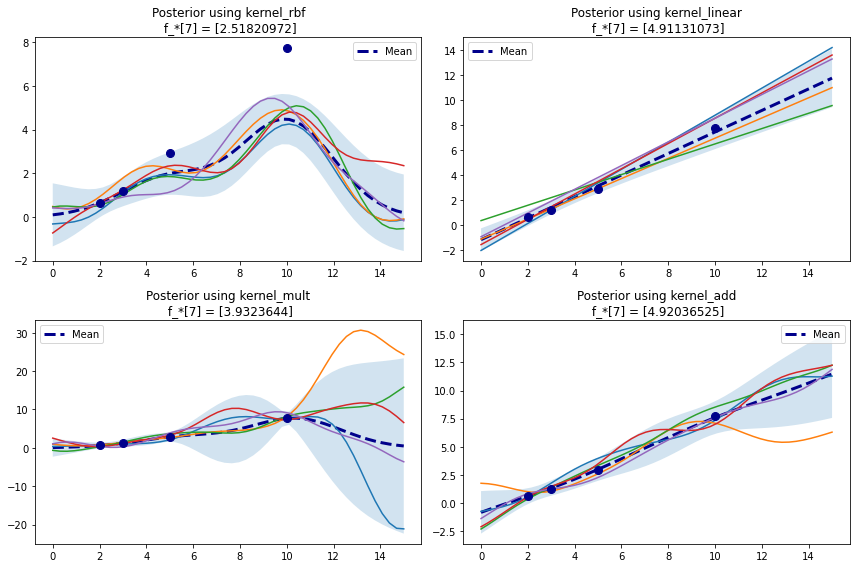

In [40]:
# compute standard deviation of histogram with probabilities p, observations o, and mean value x
def comp_sd(p, o, x):
    return np.sqrt(np.sum(p * (o - x)**2))
# compute margin of error for mean of histogram with t-value t, standard deviation sd, and sample size N
def comp_margin(t, sd, N):
    return t * (sd / np.sqrt(N))

# compute noise as 95% margins of mean for all histograms, assume sample size of N=100
sigma_f = np.array([comp_margin(t=1.962, sd=comp_sd(obs, np.arange(len(obs)), f[i]), N=100) for (obs,i) \
                   in zip(observations, np.arange(len(observations)))])

print('Margins of data values: ', sigma_f)


# Noisy training data
X = np.array([2,3,5,10]).reshape(-1,1)
N = len(X)
# Ich brauch keine noisy data, sondern assume einfach, dass meine data schon noisy ist, oder?
#f_noisy = np.array([0.64,1.21,2.93,7.76]).reshape(-1,1) + sigma_f * np.random.randn(*X.shape)


# define hyperparameters for all kernels
params = {'var': 0.8,
          'ell': 2,        
          'var_b': 2,
          'off': 0.5}

# Poster using RBF and linear kernel, and multiplication and addition of both from noisy training data
plt.figure(figsize=(12, 8))

for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_mult, kernel_add]):
    # compute mean and covariance of the posterior distribution and draw 5 samples
    mu_post, cov_post = posterior(X, X_s, f, kernel, params, noise=sigma_f)
    samples = np.random.multivariate_normal(mu_post.ravel(), cov_post, 5)
    idx_pred = np.absolute(X_s-7).argmin()
    plt.subplot(2,2,(i+1))
    plot_gp(mu_post, cov_post, X_s, X, f, samples)
    # compute prediction for x* = 7
    plt.title(f'Posterior using {kernel.__name__}\n f_*[7] = {mu_post[idx_pred]}')
plt.tight_layout()        
plt.show()

# Next Steps

## 1 Optimize hyperparameters

We consider an empirical Bayes approach to maximize the marginal likelihood   

$$ p(y|X) = \int p(y|f,X)p(f|X)df$$
in order to optimize the kernel's hyperparameters.   

The marginal likelihood can be rewritten as   
\begin{align}
\text{log}~ p(y|X) = \text{log}~ \mathcal{N}(y|0,\Sigma_y) = - \frac{1}{2} y \Sigma_y^{-1}y - \frac{1}{2} \text{log}~ |\Sigma_y| - \frac{1}{2} N \text{log}~(2\pi),
\label{eq:post}\tag{2}
\end{align}

where the first term is a data fit term, the second term a model complexity term, and the third term a constant.  

Again, we can use Cholesky decomposition for numerical stability and rewrite the log marginal likelihood:  
$ \text{log}~ p(y|X) = - \frac{1}{2} y^T \alpha - \sum_i \text{log}~ L_{ii} - \frac{1}{2} N \text{log}~(2\pi) $.

Now we want to optimize the hyperparameters by minimizing the negative log marginal likelihood with respect to the kernel parameters [2,5]. 

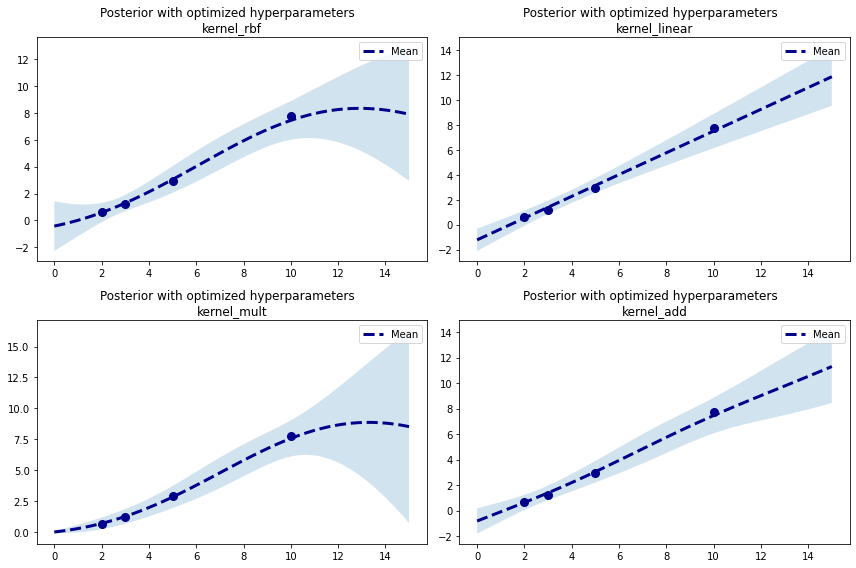

In [41]:
##### from scipy.optimize import minimize

def nll(X, f, kernel=kernel_rbf, noise=1e-2):
    """ Compute negative log marginal likelihood, naive implementation of Equation (2) or
    stable implementation using Cholesky decomposition
    
    Parameters:
    X : numpy array with N x 1 dimensions
        Training data input
    f : numpy array N x 1
        Training data output
    kernel : function (default: rbf kernel)
        Kernel function for which the parameters should be optimized
    noise : float
        Ensure that the matrix calculations work
        
    Returns:
    nll_naive 
    
    """
    
    f = f.ravel()

    def nll_naive(theta):
        params = {'var': theta[0],
                  'ell': theta[1],        
                  'var_b': theta[2],
                  'off': theta[3]}
        cov_y = kernel(X, X, params) + noise**2 * np.eye(N)
        return 0.5 * f.dot(np.linalg.inv(cov_y).dot(f)) + \
               0.5 * np.log(np.linalg.det(cov_y)) + \
               0.5 * N * np.log(2*np.pi)
    
    def nll_stable(theta):
        params = {'var': theta[0],
                  'ell': theta[1],        
                  'var_b': theta[2],
                  'off': theta[3]}
        cov_y = kernel(X, X, params)     # weniger noise wenn ich noise**2 nehm statt 1e-5
        L = np.linalg.cholesky(cov_y + 1e-5 * np.eye(N) )
        alpha_1 = np.linalg.solve(L, f)
        alpha = np.linalg.solve(L.T, alpha_1)
        
        return 0.5 * f.T.dot(alpha) + \
               np.sum(np.log(np.diagonal(L))) + \
               0.5 * N * np.log(2*np.pi)
    
    return nll_stable

    
plt.figure(figsize=(12, 8))

# Optimize parameters for all kernels: minimize nll 
for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_mult, kernel_add]):
    res = minimize(nll(X, f, kernel=kernel, noise=sigma_f), [1, 1, 1, 1],
                   bounds=((1e-2, None), (1e-2, None), (1e-2, None), (1e-2, None)),
                   method='L-BFGS-B')

    # compute posterior with optimized parameters
    var_opt, ell_opt, var_b_opt, off_opt = res.x
    params = {'var': var_opt,
              'ell': ell_opt,        
              'var_b': var_b_opt,
              'off': off_opt}

    mu_s, cov_s = posterior(X, X_s, f, kernel, params=params, noise=sigma_f)
    plt.subplot(2,2,(i+1))
    plot_gp(mu_s, cov_s, X_s, X, f)
    plt.title(f'Posterior with optimized hyperparameters  \n{kernel.__name__}')
plt.tight_layout()        
plt.show()



# Leave-one-out cross-validation (LOOCV)

To estimate the performance of the different models, we use k-fold cross-validation, where the training data is split into $k$ folds. In our case, $k=N$ is the most appropriate method, also called Leave-one-out cross-validation. Here, we train on all data cases except for $i$ in fold $i$, and then test on $i$. We leave one data point out from the training set and evaluate the prediction of the model for this data point. Each data point will be used as a test point, all other together as test set. By computing summary statistics, we get an overall evaluation of the model's performance. The reasons we use LOOCV is due to the small data size and the advantage of giving reliable and unbiased estimates of the model performance [2,7]. 

[8]: Compute test error on held out point and Average test errors!  
See https://robjhyndman.com/hyndsight/crossvalidation/

In [54]:
# Use LOOCV for specified model (kernel) and return all 4 predictions
def loocv(X, f, kernel=kernel_rbf, noise=1e-2):
    """ Leave-one-out cross-validation to compare model performances
    For each input data point, remove it from training data, then:
        Optimize hyperparameters of specified kernel 
        Derive posterior distribution with optimized parameters
        Obtain prediction for left-out data point
    
    Parameters:
    X : numpy array N x 1
        Training data input
    f : numpy array N x 1
        Training data output
    kernel : function (default: rbf kernel)
        Kernel function that specifies respective model
        
    Returns:
    predictions : list
        List of predictions of left-out training data points    
    """
    predictions = []
    N = len(X) - 1
    for leave_out in range(N+1):
        X_new = np.delete(X, leave_out).reshape(-1,1)
        f_new = np.delete(f, leave_out).reshape(-1,1)
        if len(noise)>1:
            noise_new = np.delete(noise, leave_out).reshape(-1,1)
        else:
            noise_new = noise

        res = minimize(nll(X_new, f_new, kernel=kernel, noise=noise_new), [1, 1, 1, 1],
                   bounds=((1e-2, None), (1e-2, None), (1e-2, None), (1e-2, None)),
                   method='L-BFGS-B')
        
        var_opt, ell_opt, var_b_opt, off_opt = res.x
        params = {'var': var_opt,
                  'ell': ell_opt,        
                  'var_b': var_b_opt,
                  'off': off_opt}
        mu_s, cov_s = posterior(X_new, X_s, f_new, kernel, params=params, noise=noise_new)
        
        # prediction for left out data point
        print(X_s[16])
        print(X_s[17])
        print(X[leave_out])
        print(X_s-X[leave_out])
        print(np.absolute(X_s-X[leave_out]))
        print(np.absolute(X_s-X[leave_out]).argmin())
        idx_pred = np.absolute(X_s-X[leave_out]).argmin()
        predictions.append(mu_s.item(idx_pred))

    return predictions
    
    
# compute LOOCV for all kernels
print(f'True parameters: {f.reshape(1,-1)}')
for i, kernel in enumerate([kernel_rbf, kernel_linear, kernel_mult, kernel_add]):
    # decrease N to account for smaller training set in LOOCV
    N = X.size-1    
    predictions = loocv(X=X, f=f, kernel=kernel, noise=sigma_f)
    print(f'\nPredictions for {kernel.__name__}: {predictions}')
    # L2 distance
    l2dist = np.linalg.norm(f.reshape(1,-1) - predictions)
    print(f'L2 Distance to true data point: {l2dist}')


    
        

True parameters: [[0.64 1.21 2.93 7.76]]
[4.89795918]
[5.20408163]
[2]
[[-2.        ]
 [-1.69387755]
 [-1.3877551 ]
 [-1.08163265]
 [-0.7755102 ]
 [-0.46938776]
 [-0.16326531]
 [ 0.14285714]
 [ 0.44897959]
 [ 0.75510204]
 [ 1.06122449]
 [ 1.36734694]
 [ 1.67346939]
 [ 1.97959184]
 [ 2.28571429]
 [ 2.59183673]
 [ 2.89795918]
 [ 3.20408163]
 [ 3.51020408]
 [ 3.81632653]
 [ 4.12244898]
 [ 4.42857143]
 [ 4.73469388]
 [ 5.04081633]
 [ 5.34693878]
 [ 5.65306122]
 [ 5.95918367]
 [ 6.26530612]
 [ 6.57142857]
 [ 6.87755102]
 [ 7.18367347]
 [ 7.48979592]
 [ 7.79591837]
 [ 8.10204082]
 [ 8.40816327]
 [ 8.71428571]
 [ 9.02040816]
 [ 9.32653061]
 [ 9.63265306]
 [ 9.93877551]
 [10.24489796]
 [10.55102041]
 [10.85714286]
 [11.16326531]
 [11.46938776]
 [11.7755102 ]
 [12.08163265]
 [12.3877551 ]
 [12.69387755]
 [13.        ]]
[[ 2.        ]
 [ 1.69387755]
 [ 1.3877551 ]
 [ 1.08163265]
 [ 0.7755102 ]
 [ 0.46938776]
 [ 0.16326531]
 [ 0.14285714]
 [ 0.44897959]
 [ 0.75510204]
 [ 1.06122449]
 [ 1.36734694

[4.89795918]
[5.20408163]
[2]
[[-2.        ]
 [-1.69387755]
 [-1.3877551 ]
 [-1.08163265]
 [-0.7755102 ]
 [-0.46938776]
 [-0.16326531]
 [ 0.14285714]
 [ 0.44897959]
 [ 0.75510204]
 [ 1.06122449]
 [ 1.36734694]
 [ 1.67346939]
 [ 1.97959184]
 [ 2.28571429]
 [ 2.59183673]
 [ 2.89795918]
 [ 3.20408163]
 [ 3.51020408]
 [ 3.81632653]
 [ 4.12244898]
 [ 4.42857143]
 [ 4.73469388]
 [ 5.04081633]
 [ 5.34693878]
 [ 5.65306122]
 [ 5.95918367]
 [ 6.26530612]
 [ 6.57142857]
 [ 6.87755102]
 [ 7.18367347]
 [ 7.48979592]
 [ 7.79591837]
 [ 8.10204082]
 [ 8.40816327]
 [ 8.71428571]
 [ 9.02040816]
 [ 9.32653061]
 [ 9.63265306]
 [ 9.93877551]
 [10.24489796]
 [10.55102041]
 [10.85714286]
 [11.16326531]
 [11.46938776]
 [11.7755102 ]
 [12.08163265]
 [12.3877551 ]
 [12.69387755]
 [13.        ]]
[[ 2.        ]
 [ 1.69387755]
 [ 1.3877551 ]
 [ 1.08163265]
 [ 0.7755102 ]
 [ 0.46938776]
 [ 0.16326531]
 [ 0.14285714]
 [ 0.44897959]
 [ 0.75510204]
 [ 1.06122449]
 [ 1.36734694]
 [ 1.67346939]
 [ 1.97959184]
 [ 2.2857

# AIC

## 2 Multiple dimensions

# Compare with scikit's Gaussian Process Implementation [6]

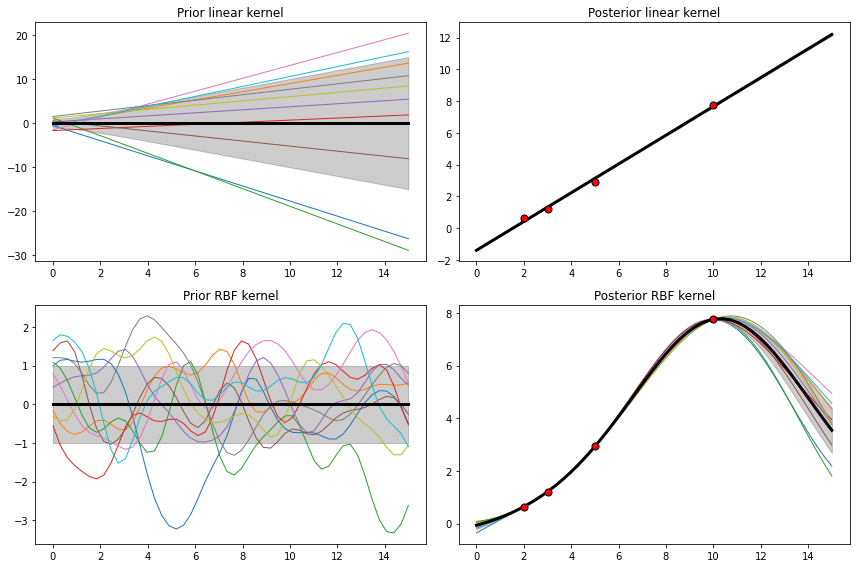

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF


gpr_l = GaussianProcessRegressor(kernel=DotProduct())
gpr_r = GaussianProcessRegressor(kernel=RBF())

X_s_ = np.linspace(0, 15, N_s)
X_ = np.array([2,3,5,10]).reshape(-1,1)
f_ = np.array([0.64,1.21,2.93,7.76])

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
y_mean_l, y_std_l = gpr_l.predict(X_s_[:, np.newaxis], return_std=True)
plt.plot(X_s_, y_mean_l, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_l - y_std_l, y_mean_l + y_std_l,
                     alpha=0.2, color='k')
y_samples_l = gpr_l.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_l, lw=1)
plt.title("Prior linear kernel")

gpr_l.fit(X_,f_)

y_mean_l, y_std_l = gpr_l.predict(X_s_[:, np.newaxis], return_std=True)
plt.subplot(2, 2, 2)
plt.plot(X_s_, y_mean_l, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_l - y_std_l, y_mean_l + y_std_l,
                     alpha=0.2, color='k')
y_samples_l = gpr_l.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_l, lw=1)
plt.scatter(X_[:, 0], f_, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tight_layout()
plt.title("Posterior linear kernel")


plt.subplot(2, 2, 3)
y_mean_r, y_std_r = gpr_r.predict(X_s_[:, np.newaxis], return_std=True)
plt.plot(X_s_, y_mean_r, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_r - y_std_r, y_mean_r + y_std_r,
                     alpha=0.2, color='k')
y_samples_r = gpr_r.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_r, lw=1)
plt.title("Prior RBF kernel")

gpr_r.fit(X_,f_)

y_mean_r, y_std_r = gpr_r.predict(X_s_[:, np.newaxis], return_std=True)
plt.subplot(2, 2, 4)
plt.plot(X_s_, y_mean_r, 'k', lw=3, zorder=9)
plt.fill_between(X_s_, y_mean_r - y_std_r, y_mean_r + y_std_r,
                     alpha=0.2, color='k')
y_samples_r = gpr_r.sample_y(X_s_[:, np.newaxis], 10)
plt.plot(X_s_, y_samples_r, lw=1)
plt.scatter(X_[:, 0], f_, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.tight_layout()
plt.title("Posterior RBF kernel")



plt.show()

# References

[1] Jochen  Görtler,  Rebecca  Kehlbeck,  and  Oliver  Deussen.   A  visual  exploration  of gaussian processes. Distill, 4:e17, 2019.  
[2] Kevin P. Murphy. Machine Learning: a probabilistic perspective.  MIT press, 2012.   
[3] Rasmussen, Carl Edward. Gaussian processes in machine learning. In Summer school on machine learning, Springer, 2003.  
[4] https://www.cs.toronto.edu/~duvenaud/cookbook/  
[5] https://krasserm.github.io/2018/03/19/gaussian-processes/  
[6] https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html  
[7] https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/  
[8] https://web.stanford.edu/class/stats202/notes/Resampling/LOOCV.html